# Project-1-Spotify

We are a consulting company for independent artists. We are helping a new Mexican artist to launch their next hit in Mexico and Latin America, which is planned to be released in last quarter 2020 in the Spotify platform, to remain in the Top 50 Chart throughout the next year.

Tasks:

* Identify most popular music genres in the population segment that the artist is targeting.
* Identify patterns in the tempo, energy, danceability and acousticness of the music that people in that segment listen to in different quarters.
* Define the properties that the artist's song should have to be succesful in last quarter 2020 in Mexico and Latin America.
* Predict how popular this song will be in upcoming quarters.


## Data preparation

In [2]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import csv

#Import Top 50 chart and Stats table. Get track ID from URL.
top50_chart_df = pd.read_excel("chartmx_03_20.xlsx", index = False)
stats_df = pd.read_excel("audiofmx.xlsx", index = False)

top50_chart_df["id"] = top50_chart_df["URL"].str[-22:]


In [3]:
#Select columns from both Data Frames
top50_chart_df = top50_chart_df[["Position", "Track Name", "Artist", "Date", "id"]]
stats_df = stats_df[["acousticness", "danceability", "duration_ms", "energy", "id", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "type", "valence"]]

In [4]:
#Import genre data set from 'tsv' file as list.
genres_tsv = os.path.join("songDb.tsv")
with open(genres_tsv, "r") as csvfile:
    csvreader = csv.reader(csvfile, delimiter = "\t")
    genres_data = list(csvreader)

#Remove empty rows from original list.
genres_data_clean = []
for element in genres_data:
    if element != []:
        genres_data_clean.append(element)

#Convert original data set to Pandas DataFrame and promote first row as header.
genres_df = pd.DataFrame(genres_data_clean)
new_header = genres_df.iloc[0]
genres_df = genres_df[1:]
genres_df.columns = new_header
genres_df = genres_df.rename(columns = {"ID": "id"})
genres_df = genres_df[["id", "Genre"]]

In [5]:
#Merge Top 50 chart DataFrame with stats DataFrame in `complete_df` DataFrame.
complete_df = top50_chart_df.merge(stats_df, on = "id")
complete_df = complete_df[["Position", "Track Name", "Artist", "Date", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "type", "valence", "id"]]

#Merge `complete_df` DataFrame with genre DataFrame. Remove NA's
complete_df = complete_df.merge(genres_df, on = "id")
complete_df = complete_df.dropna()
complete_df.head()

,Position,Track Name,Artist,Date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,type,valence,id,Genre
0,7,Hear Me Now,Alok,2017-01-01,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism
1,7,Hear Me Now,Alok,2017-01-02,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism
2,10,Hear Me Now,Alok,2017-01-03,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism
3,11,Hear Me Now,Alok,2017-01-04,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism
4,14,Hear Me Now,Alok,2017-01-05,0.586,0.789,192846,0.442,0.00366,11,0.0927,-7.844,1,0.0421,121.971,4,audio_features,0.45,1a5Yu5L18qNxVhXx38njON,indiepoptimism


**Hypothesis: If we determine the optimal mix of the variables related to a successful song in Mexico, then we can help the artist release a successful song in the last quarter of 2020:**

**If the tempo of a song is higher than 100 bpm, then it will be more popular.**

We will start by characterizing the tempos in 70 equally spaced bins.

In [6]:
def bins_list (min, max, bins):
    
    # Returns an array containing enough numbers to evenly cut in bins a range of numbers. 
    
    values = []
    x = min
    step = (max - min) / bins
    while x <= max:
        values.append(x)
        x += step
        
    return values

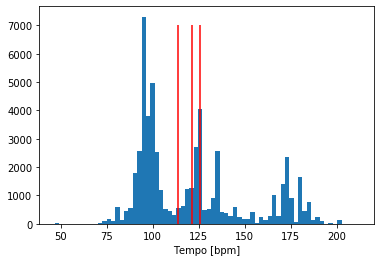

In [7]:
tempo_min = complete_df["tempo"].min()
tempo_max = complete_df["tempo"].max()

tempo_bins = bins_list(tempo_min, tempo_max, 70)

complete_mean = complete_df["tempo"].mean()
complete_mode = complete_df["tempo"].mode()
complete_median = complete_df["tempo"].median()


tempo_category = pd.cut(complete_df["tempo"], bins = tempo_bins)
complete_df["Tempo Category"] = tempo_category
plt.hist(complete_df["tempo"], tempo_bins)
plt.xlabel("Tempo [bpm]")
#plt.ylabel("Appearances in Top 50 Chart")
plt.vlines(complete_mean, 0, 7000, color = "red")
plt.vlines(complete_mode, 0, 7000, color = "red")
plt.vlines(complete_median, 0, 7000, color = "red")
#plt.text(125,4000,f"Mode: {round(complete_mean,2)} bpm ", color = "red", size = "large")
plt.show()

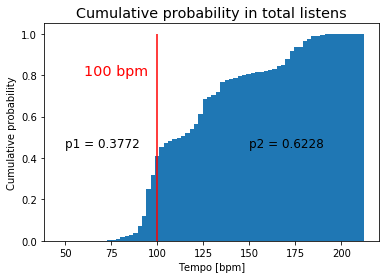

In [8]:
complete_df["Tempo Category"] = tempo_category
plt.hist(complete_df["tempo"], tempo_bins, cumulative = True, density = True)
plt.xlabel("Tempo [bpm]")
plt.ylabel("Cumulative probability")
p_less_100 = complete_df["tempo"].loc[complete_df["tempo"] < 100].count() / complete_df["Track Name"].count()
p_more_100 = complete_df["tempo"].loc[complete_df["tempo"] > 100].count() / complete_df["Track Name"].count()
plt.vlines(100, 0, 1, color = "red")
plt.text(150, 0.45, f"p2 = {round(p_more_100,4)}", size = "large")
plt.text(50, 0.45, f"p1 = {round(p_less_100,4)}", size = "large")
plt.text(60, 0.8, "100 bpm", c = "red", size = "x-large")
plt.title("Cumulative probability in total listens", size = "x-large")
plt.show()

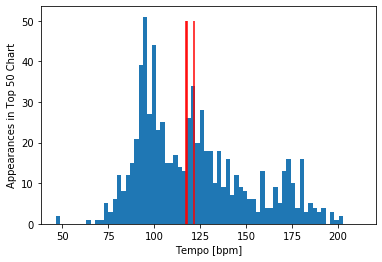

In [9]:
unique_df = complete_df.drop_duplicates(subset = "id")
unique_df = unique_df[["Track Name", "tempo", "Tempo Category", "Genre"]]
unique_mode = unique_df["tempo"].mode()
unique_median = unique_df["tempo"].median()
unique_mean = unique_df["tempo"].mean()

plt.hist(unique_df["tempo"], tempo_bins)
plt.xlabel("Tempo [bpm]")
plt.ylabel("Appearances in Top 50 Chart")
plt.vlines(unique_mode, 0, 50, color = "red")
plt.vlines(unique_median, 0, 50, color = "red")
plt.vlines(unique_mean, 0, 50, color = "red")
#plt.text(125,150,f"Mode: {round(unique_mode,2)} bpm", color = "red", size = "large")
plt.show()

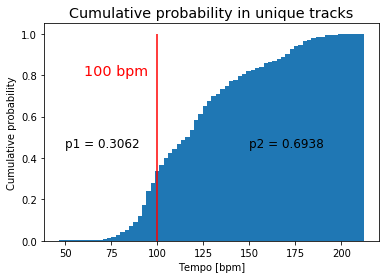

In [10]:
unique_df["Tempo Category"] = tempo_category
plt.hist(unique_df["tempo"], tempo_bins, cumulative = True, density = True)
plt.xlabel("Tempo [bpm]")
plt.ylabel("Cumulative probability")
p_less_100 = unique_df["tempo"].loc[unique_df["tempo"] < 100].count() / unique_df["Track Name"].count()
p_more_100 = unique_df["tempo"].loc[unique_df["tempo"] > 100].count() / unique_df["Track Name"].count()
plt.vlines(100, 0, 1, color = "red")
plt.text(150, 0.45, f"p2 = {round(p_more_100,4)}", size = "large")
plt.text(50, 0.45, f"p1 = {round(p_less_100,4)}", size = "large")
plt.text(60, 0.8, "100 bpm", c = "red", size = "x-large")
plt.title("Cumulative probability in unique tracks", size = "x-large")
plt.show()

In [11]:
stats.ttest_ind(complete_df["tempo"], unique_df["tempo"])

Ttest_indResult(statistic=-0.20843171986979858, pvalue=0.8348926451421976)

Our hypothesis test indicates that there is no difference between the mean value observed in a complete data set (containing all appearances in the Top 50 charts of a given song in the last three years) and the mean value observed in the set containing the unique values of songs. Since p > 0.05 for this test, we can thus accept our null hypothesis and consider that both distributions are similar. Then, tempo is a relevant factor for the popularity of a song.

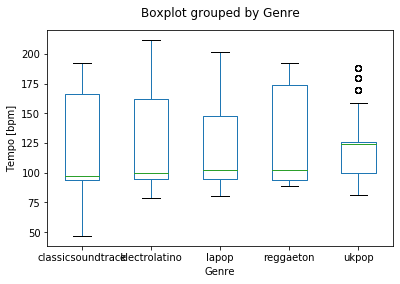

In [13]:
#unique_df.head()
#unique_df.boxplot("tempo", by = "Genre")

#unique_df["Genre"].value_counts()
#print(complete_df["Genre"].value_counts())

most_popular_df = complete_df.loc[(complete_df["Genre"] == "lapop") |
                                  (complete_df["Genre"] == "electrolatino") |
                                  (complete_df["Genre"] == "classicsoundtrack") |
                                  (complete_df["Genre"] == "ukpop") |
                                  (complete_df["Genre"] == "reggaeton"),:]

plot = most_popular_df.boxplot("tempo", by = "Genre", grid = False)
plot.set_ylabel("Tempo [bpm]")
plot.set_title("")
plot

## If the chooses to release a reggaeton song, then it will remain in the Top 50 Chart throughout the next year.

## If a song has a higher level of energy, then it will be more likely to be in the Top 50 throughout the next year.

In [12]:
genre_extract_df = complete_df[["Position", "Track Name", "Artist", "Date", "id", "Genre"]]
genre_df=genre_extract_df['Genre'].value_counts()
genre_df=pd.DataFrame(genre_df)
genre_df=genre_df.sort_values('Genre',ascending=False)
genre_df=genre_df.reset_index()
genre_df=genre_df.rename(columns={'Genre':'Num of songs', 'index':'Genre'})
top15_genre_df=genre_df.nlargest(5, ['Num of songs'])
top15_genre_df

,Genre,Num of songs
0,lapop,8340
1,electrolatino,7626
2,classicsoundtrack,3531
3,ukpop,2974
4,reggaeton,2259


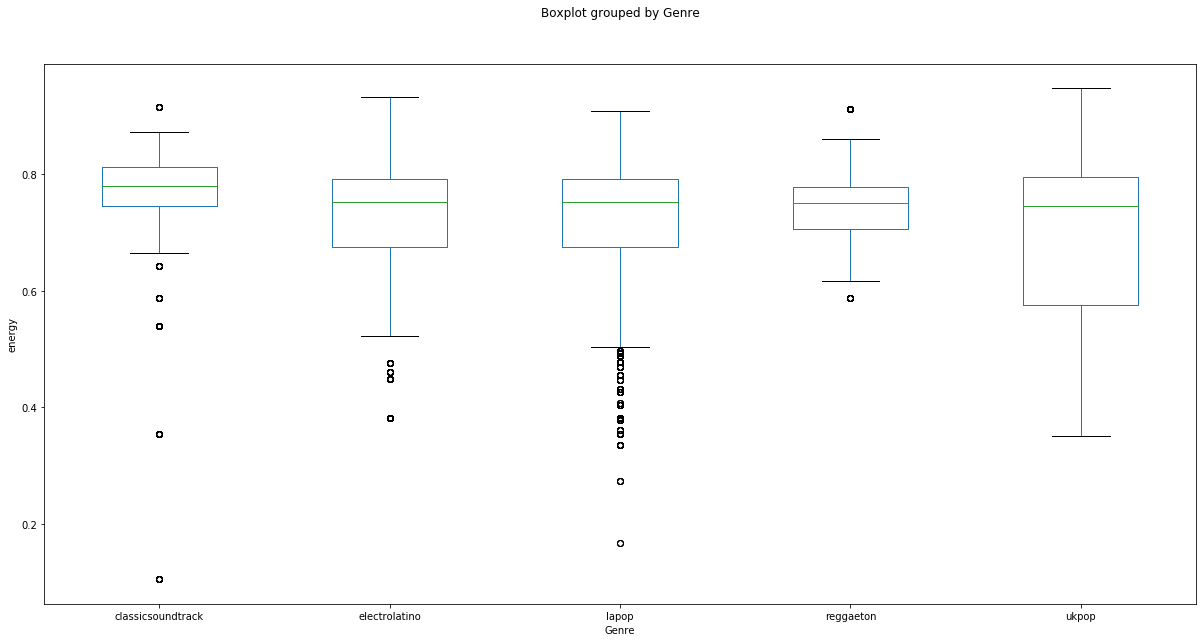

In [15]:
most_popular_df_energy = complete_df.loc[(complete_df["Genre"] == "lapop") |
                                         (complete_df["Genre"] == "electrolatino") |
                                         (complete_df["Genre"] == "classicsoundtrack") |
                                         (complete_df["Genre"] == "ukpop") |
                                         (complete_df["Genre"] == "reggaeton"),:]

plot = most_popular_df.boxplot("energy", by = "Genre", grid = False,figsize=(20,10))
plot.set_ylabel("energy")
plot.set_title("")
plot
plot

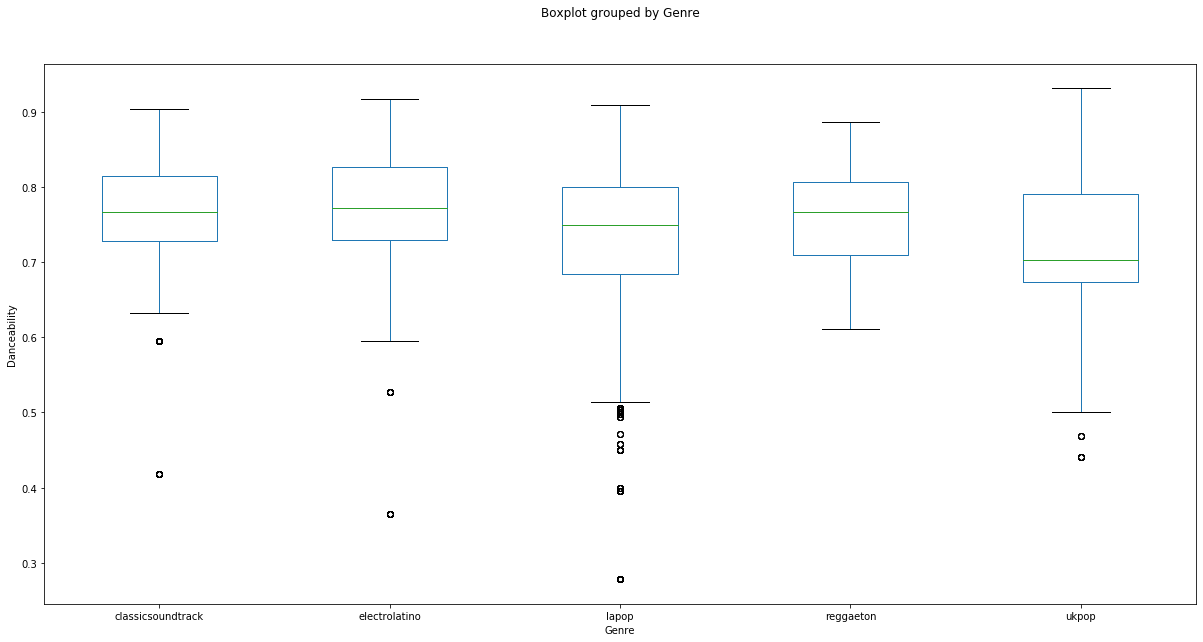

In [16]:
most_popular_df_dance = complete_df.loc[(complete_df["Genre"] == "lapop") |
                                         (complete_df["Genre"] == "electrolatino") |
                                         (complete_df["Genre"] == "classicsoundtrack") |
                                         (complete_df["Genre"] == "ukpop") |
                                         (complete_df["Genre"] == "reggaeton"),:]

plot = most_popular_df.boxplot("danceability", by = "Genre", grid = False,figsize=(20,10))
plot.set_ylabel("Danceability")
plot.set_title("")
plot
plot

In [18]:
group1=most_popular_df_dance[most_popular_df_dance["Genre"]=="lapop"]["danceability"]
group2=most_popular_df_dance[most_popular_df_dance["Genre"]=="electrolatino"]["danceability"]
group3=most_popular_df_dance[most_popular_df_dance["Genre"]=="classicsoundtrack"]["danceability"]
group4=most_popular_df_dance[most_popular_df_dance["Genre"]=="ukpop"]["danceability"]
group5=most_popular_df_dance[most_popular_df_dance["Genre"]=="ukpop"]["danceability"]

In [19]:
stats.f_oneway(group1,group2,group3,group4,group5)

F_onewayResult(statistic=305.6158719189037, pvalue=3.1094655330479858e-257)

Text(0.5, 1.0, 'Energy of songs of Genre Latin Pop')

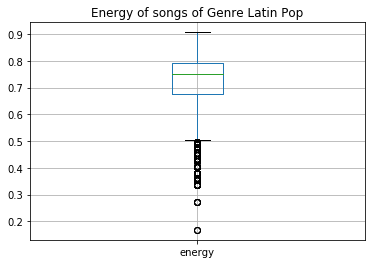

In [13]:
genre_lapop=pd.DataFrame(complete_df[complete_df["Genre"]=="lapop"]["energy"])
box_g=genre_lapop.boxplot()
box_g.set_title('Energy of songs of Genre Latin Pop')


In [14]:
genre_lapop_quart=genre_lapop["energy"]
genre_lapop_quart

37       0.838
38       0.838
39       0.838
40       0.838
41       0.838
         ...  
55534    0.588
55542    0.588
55550    0.588
55558    0.588
55566    0.588
Name: energy, Length: 8340, dtype: float64

In [15]:
quartiles_lapop=genre_lapop_quart.quantile([.25,.5,.75])
lowerq_lapop=quartiles_lapop[0.25]
upperq_lapop=quartiles_lapop[0.75]
iqr_lapop=upperq_lapop-lowerq_lapop

print(f"The lower quartile of energy in latin pop is: {lowerq_lapop}")
print(f"The upper quartile of energy in latin pop is: {upperq_lapop}")
print(f"The upper interquartile range of energy in latin pop is: {iqr_lapop}")
print(f"The median of energy in latin pop is: {quartiles_lapop[0.5]}")

lower_bound_lapop=lowerq_lapop - (1.5*iqr_lapop)
upper_bound_lapop=upperq_lapop + (1.5*iqr_lapop)
print(f"Values below {lower_bound_lapop} could be the outliers.")
print(f"Values above {upper_bound_lapop} could be the outliers.")

The lower quartile of energy in latin pop is: 0.675
The upper quartile of energy in latin pop is: 0.791
The upper interquartile range of energy in latin pop is: 0.11599999999999999
The median of energy in latin pop is: 0.752
Values below 0.5010000000000001 could be the outliers.
Values above 0.9650000000000001 could be the outliers.


Text(0.5, 1.0, 'Energy of songs of Electolatino')

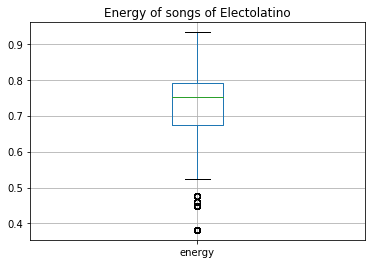

In [16]:
genre_electo=pd.DataFrame(complete_df[complete_df["Genre"]=="electrolatino"]["energy"])
box_ge=genre_electo.boxplot()
box_ge.set_title('Energy of songs of Electolatino')

In [17]:
electro_data=genre_electo["energy"]
electro_data

2618     0.874
2619     0.874
2620     0.874
2621     0.874
3169     0.829
         ...  
55562    0.588
55564    0.588
55569    0.588
55570    0.588
55572    0.588
Name: energy, Length: 7626, dtype: float64

In [18]:
qelectro=electro_data.quantile([.25,.5,.75])
lelectro=qelectro[0.25]
uelectro=qelectro[0.75]
ielectro=uelectro-lelectro
loelectro=lelectro-(1.5*ielectro)
upelectro=uelectro+(1.5*ielectro)
print(f"The lower quartile of energy in electrolatin is:{lelectro}")
print(f"The upper quartile of energy in electrolatin is:{uelectro}")
print(f"The median of energy in electrolatin is:{qelectro[0.5]}")
print(f"Values below {loelectro} could be outliers")


The lower quartile of energy in electrolatin is:0.675
The upper quartile of energy in electrolatin is:0.791
The median of energy in electrolatin is:0.752
Values below 0.5010000000000001 could be outliers


Text(0.5, 1.0, 'Energy of Classic Songs')

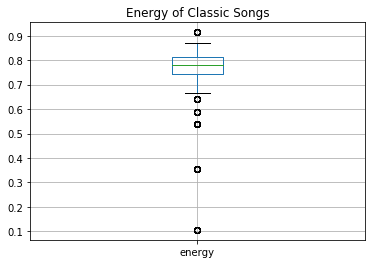

In [19]:
classicsoundtrack=pd.DataFrame(complete_df[complete_df["Genre"]=="classicsoundtrack"]["energy"])
classic_data=classicsoundtrack.boxplot()
classic_data.set_title('Energy of Classic Songs')

In [20]:
classic_data_df=classicsoundtrack["energy"]
qclassoc=classic_data_df.quantile([.25,.5,.75])
lclassic=qclassoc[0.25]
uclassic=qclassoc[0.75]
iclassic=uclassic-lclassic
loclassic=lclassic-(1.5*iclassic)
upclassic=uclassic+(1.5*iclassic)
print(f"The lower quartile of energy in classic is:{lclassic}")
print(f"The upper quartile of energy in classic is:{uclassic}")
print(f"The median of energy in classic is:{qclassoc[0.5]}")
print(f"Values below {loclassic} could be outliers")

The lower quartile of energy in electrolatin is:0.745
The upper quartile of energy in electrolatin is:0.811
The median of energy in electrolatin is:0.779
Values below 0.6459999999999999 could be outliers


Text(0.5, 1.0, 'Energy of UKPop Songs')

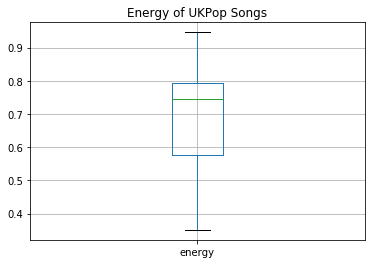

In [31]:
ukpop=pd.DataFrame(complete_df[complete_df["Genre"]=="ukpop"]["energy"])
ukpop_data=ukpop.boxplot()
ukpop_data.set_title('Energy of UKPop Songs')

In [32]:
ukpop_data_df=ukpop["energy"]
qukpop=ukpop_data_df.quantile([.25,.5,.75])
lukpop=qukpop[0.25]
uukpop=qukpop[0.75]
iukpop=uukpop-lukpop
loukpop=lukpop-(1.5*iukpop)
upukpop=uukpop+(1.5*iukpop)
print(f"The lower quartile of energy in UKPop is:{lukpop}")
print(f"The upper quartile of energy in UKPop is:{uukpop}")
print(f"The median of energy in UKPop is:{qukpop[0.5]}")
print(f"Values below {loukpop} could be outliers")

The lower quartile of energy in UKPop is:0.575
The upper quartile of energy in UKPop is:0.794
The median of energy in UKPop is:0.744
Values below 0.24649999999999983 could be outliers


Text(0.5, 1.0, 'Energy of Reggaeton Songs')

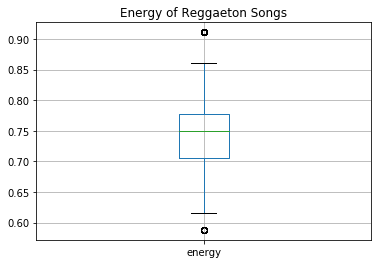

In [33]:
reggaeton=pd.DataFrame(complete_df[complete_df["Genre"]=="reggaeton"]["energy"])
reggaeton_data=reggaeton.boxplot()
reggaeton_data.set_title('Energy of Reggaeton Songs')

In [34]:
reggaeton_data_df=reggaeton["energy"]
qreggaeton=reggaeton_data_df.quantile([.25,.5,.75])
lreggaeton=qreggaeton[0.25]
ureggaeton=qreggaeton[0.75]
ireggaeton=ureggaeton-lreggaeton
loreggaeton=lreggaeton-(1.5*ireggaeton)
upreggaeton=ureggaeton+(1.5*ireggaeton)
print(f"The lower quartile of energy in reggaeton is:{lreggaeton}")
print(f"The upper quartile of energy in reggaeton is:{ureggaeton}")
print(f"The median of energy in reggaeton is:{qreggaeton[0.5]}")
print(f"Values below {loreggaeton} could be outliers")
print(f"Values above {upreggaeton} could be outliers")

The lower quartile of energy in reggaeton is:0.706
The upper quartile of energy in reggaeton is:0.777
The median of energy in reggaeton is:0.75
Values below 0.5994999999999999 could be outliers
Values above 0.8835000000000002 could be outliers


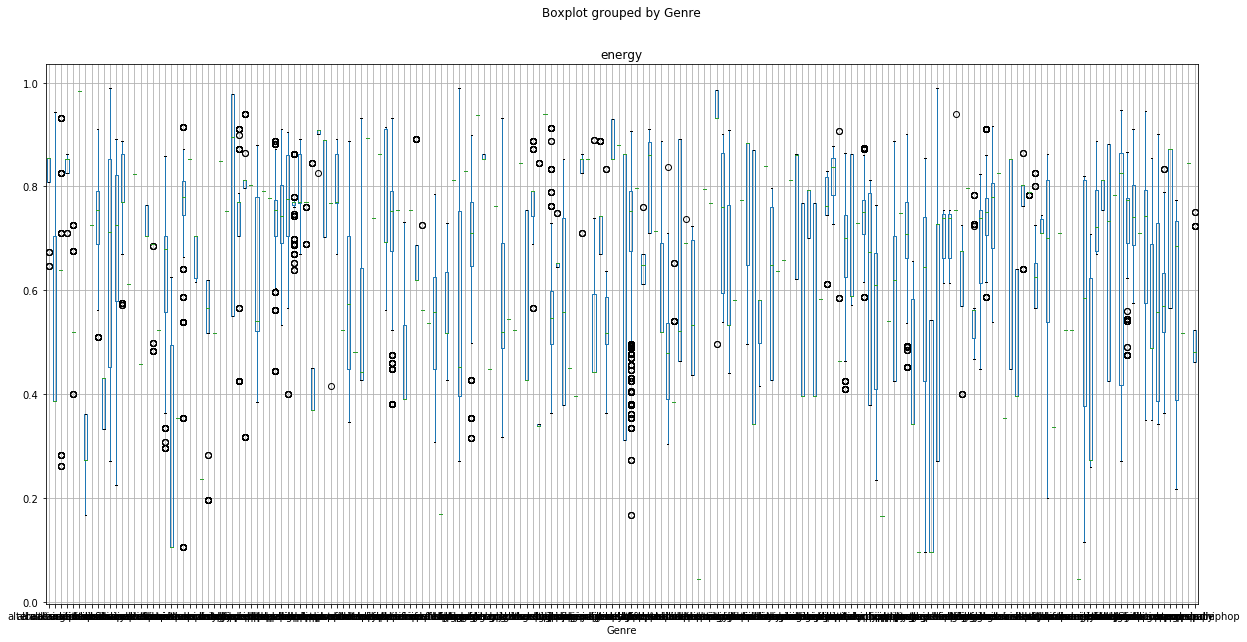

In [35]:
complete_df.boxplot("energy",by="Genre",figsize=(20,10))

## If a song has a higher level of danceability, then it will be more likely to be in the Top 50 throughout the next year.

Text(0.5, 1.0, 'Energy of Reggaeton Songs')

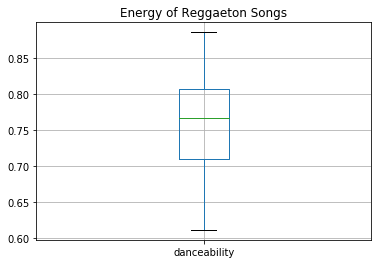

In [30]:
dance_regg=pd.DataFrame(complete_df[complete_df["Genre"]=="reggaeton"]["danceability"])
dance_data=dance_regg.boxplot()
dance_data.set_title('Danceability of Reggaeton Songs')

In [40]:
reggaeton_data_danceability=dance_regg["danceability"]
qreggaeton_dance=reggaeton_data_danceability.quantile([.25,.5,.75])
lreggaeton_dance=qreggaeton_dance[0.25]
ureggaeton_dance=qreggaeton_dance[0.75]
ireggaeton_dance=ureggaeton_dance-lreggaeton_dance
loreggaeton_dance=lreggaeton_dance-(1.5*ireggaeton_dance)
upreggaeton_dance=ureggaeton_dance+(1.5*ireggaeton_dance)
print(f"The lower quartile of danceability in reggaeton is:{lreggaeton_dance}")
print(f"The upper quartile of danceability in reggaeton is:{ureggaeton_dance}")
print(f"The median of danceability in electrolatin is:{qreggaeton_dance[0.5]}")

The lower quartile of danceability in reggaeton is:0.709
The upper quartile of danceability in reggaeton is:0.807
The median of danceability in electrolatin is:0.767


Text(0.5, 1.0, 'Danceability of electrolatino Songs')

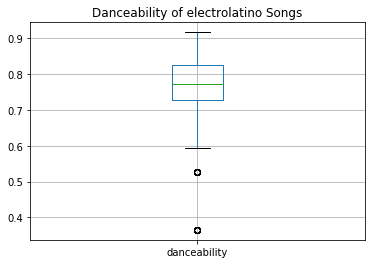

In [41]:
dance_electrolatino=pd.DataFrame(complete_df[complete_df["Genre"]=="electrolatino"]["danceability"])
dance_data_electrolatino=dance_electrolatino.boxplot()
dance_data_electrolatino.set_title('Danceability of electrolatino Songs')

In [42]:
electrolatino_data_danceability=dance_electrolatino["danceability"]
qelectrolatino_dance=electrolatino_data_danceability.quantile([.25,.5,.75])
lelectrolatino_dance=qelectrolatino_dance[0.25]
uelectrolatino_dance=qelectrolatino_dance[0.75]
ielectrolatino_dance=uelectrolatino_dance-lelectrolatino_dance
loelectrolatino_dance=lelectrolatino_dance-(1.5*ielectrolatino_dance)
upelectrolatino_dance=uelectrolatino_dance+(1.5*ielectrolatino_dance)
print(f"The lower quartile of danceability in electrolatino is:{lelectrolatino_dance}")
print(f"The upper quartile of danceability in electrolatino is:{uelectrolatino_dance}")
print(f"The median of danceability in electrolatino is:{qelectrolatino_dance[0.5]}")

The lower quartile of danceability in electrolatino is:0.7290000000000001
The upper quartile of danceability in electrolatino is:0.826
The median of danceability in electrolatino is:0.772


Text(0.5, 1.0, 'Danceability of electrolatino Songs')

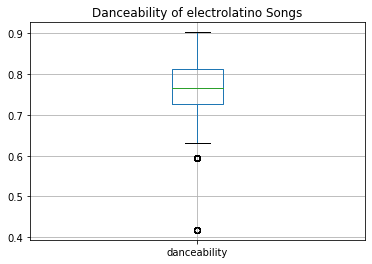

In [43]:
dance_classicsoundtrack=pd.DataFrame(complete_df[complete_df["Genre"]=="classicsoundtrack"]["danceability"])
dance_data_classicsoundtrack=dance_classicsoundtrack.boxplot()
dance_data_classicsoundtrack.set_title('Danceability of Classic Songs')

In [44]:
classic_data_danceability=dance_classicsoundtrack["danceability"]
qclassic_dance=classic_data_danceability.quantile([.25,.5,.75])
lclassic_dance=qclassic_dance[0.25]
uclassic_dance=qclassic_dance[0.75]
iclassic_dance=uclassic_dance-lclassic_dance
loclassic_dance=lclassic_dance-(1.5*iclassic_dance)
upclassicdance=uclassic_dance+(1.5*iclassic_dance)
print(f"The lower quartile of danceability in electrolatino is:{lclassic_dance}")
print(f"The upper quartile of danceability in electrolatino is:{uclassic_dance}")
print(f"The median of danceability in electrolatino is:{qclassic_dance[0.5]}")

The lower quartile of danceability in electrolatino is:0.728
The upper quartile of danceability in electrolatino is:0.814
The median of danceability in electrolatino is:0.766
